
## Flash Flood Study Exploratory Data Analysis (EDA) using the NAM 15-03Z BUFRs

In [1]:
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import glob
import sklearn.ensemble as ens
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn import metrics
from sklearn.base import clone
from sklearn.ensemble.forest import _generate_unsampled_indices
warnings.filterwarnings('ignore')
from rfpimp import *

Populating the interactive namespace from numpy and matplotlib


/Users/nicholascarr/anaconda/envs/flood/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
def plot_heatmap(df, site_name):

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Correlations between predictors for {}'.format(site_name),
              fontweight='bold', fontsize=16)
    corr = df.corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.savefig('Heatmap{}'.format(site_name))


def importance_plot(predictors, feature_imp, site_name):
  
    labels = feature_imp.index.tolist()
    indices = np.argsort(feature_imp)[::-1]
    plt.figure(figsize=(22,10))
    plt.title("Feature importances for {}".format(site_name),
              fontweight='bold', fontsize=20)
    plt.bar(range(predictors.shape[1]), feature_imp[indices],
            color="r", align="center")
    plt.xticks(range(predictors.shape[1]), labels, fontweight='bold', fontsize=7.7)
    plt.xlim([-1, predictors.shape[1]])
    plt.savefig('Feature_Imp{}'.format(site_name))
    

def boxplot(df, feature_imp, site_name, n_features=6):
    if n_features %2 != 0:
        raise ValueError('Must be even number of features')
    df['Text_Result'] = np.nan
    df.loc[(df.Result == 0), 'Text_Result'] = 'No Flooding'
    df.loc[(df.Result == 1), 'Text_Result'] = 'Widespread Flooding'
    fix, axes = plt.subplots ((n_features / 2), 2, figsize=(16,16))
    plt.suptitle('Boxplot for {}'.format(site_name), fontweight='bold', fontsize=18)
    axs = axes.ravel()

    #Only plot 8 most important features
    for i, feature in enumerate(feature_imp.index[:n_features]):
        boxplot = sns.boxplot(x='Text_Result', y=feature, data=df, width=0.5, 
                              order= ['No Flooding', 'Widespread Flooding'], ax=axs[i])
        plt.savefig('boxplot{}'.format(site_name))

## Let's look at correlations and dependences among the predictors

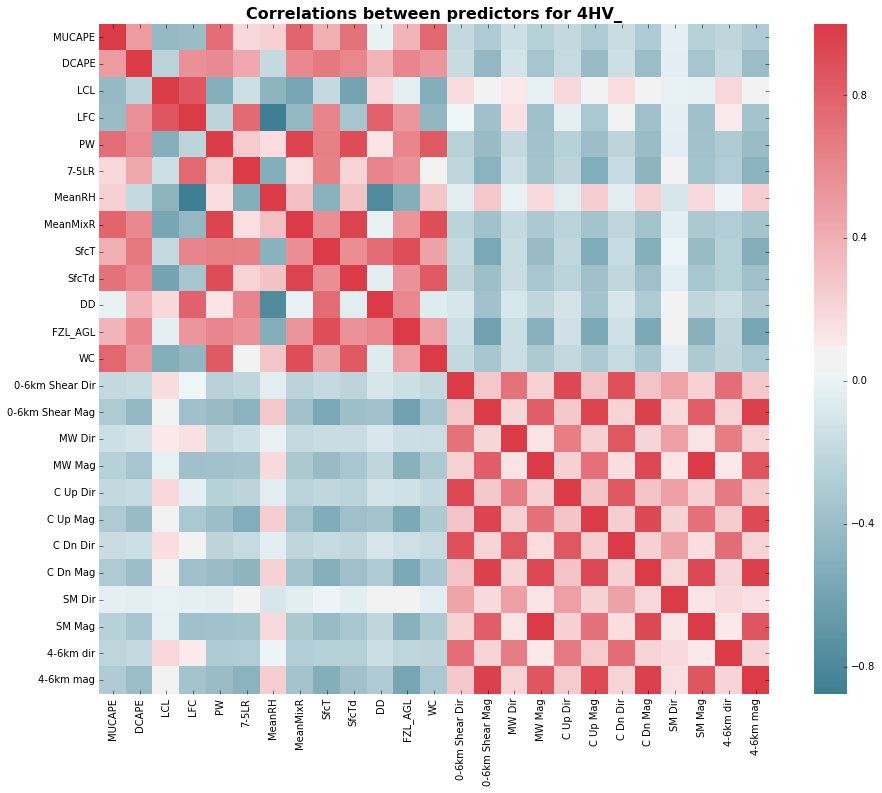

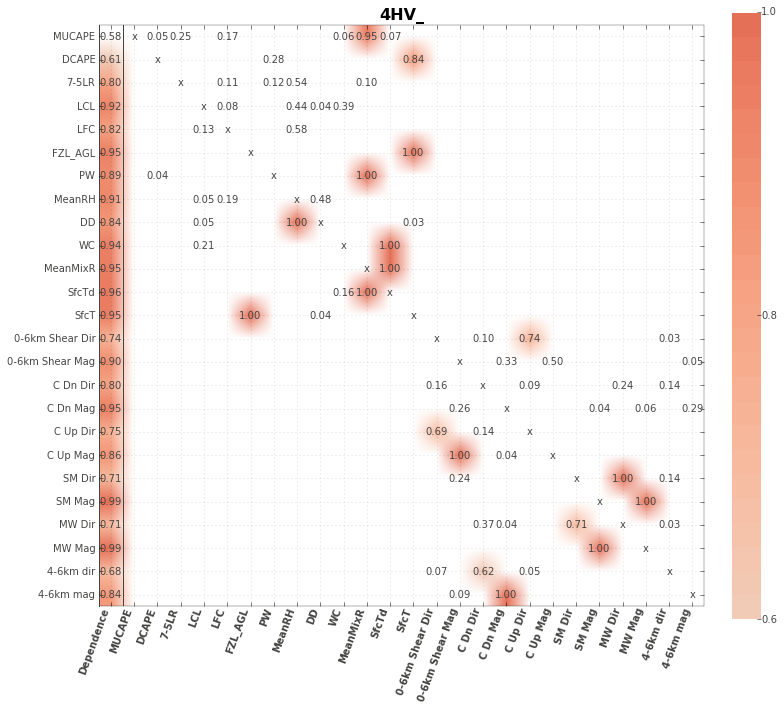

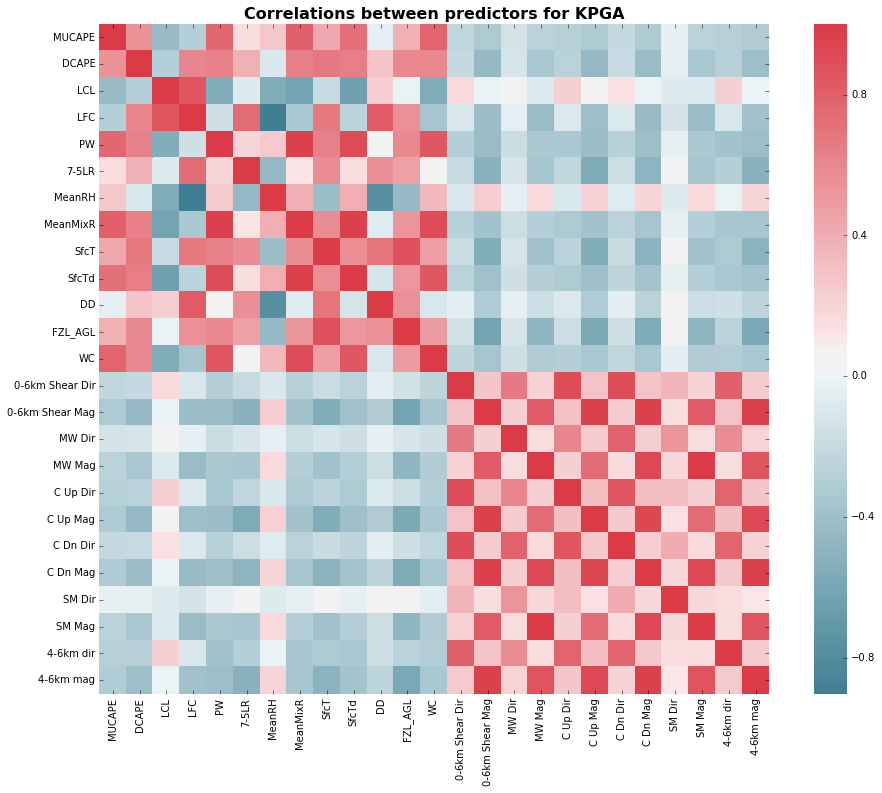

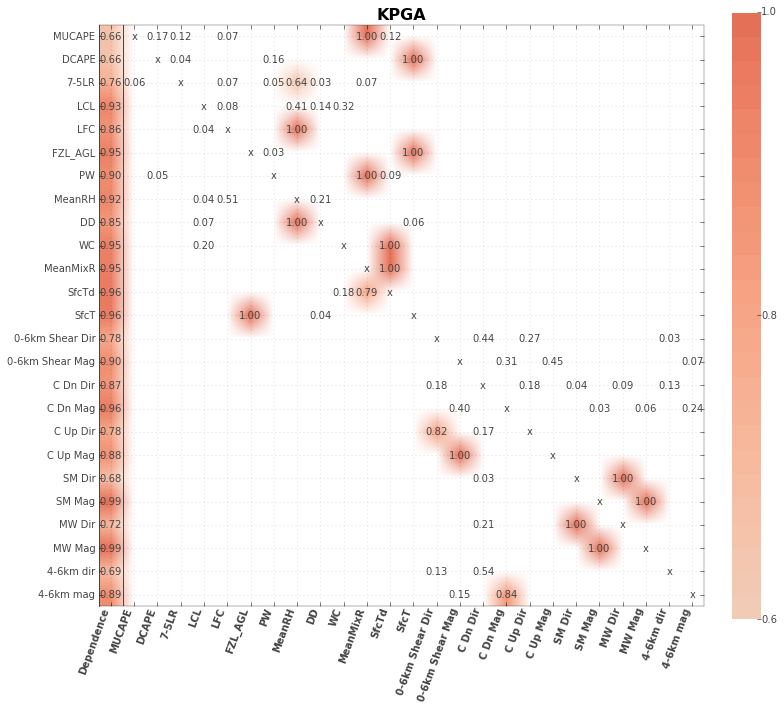

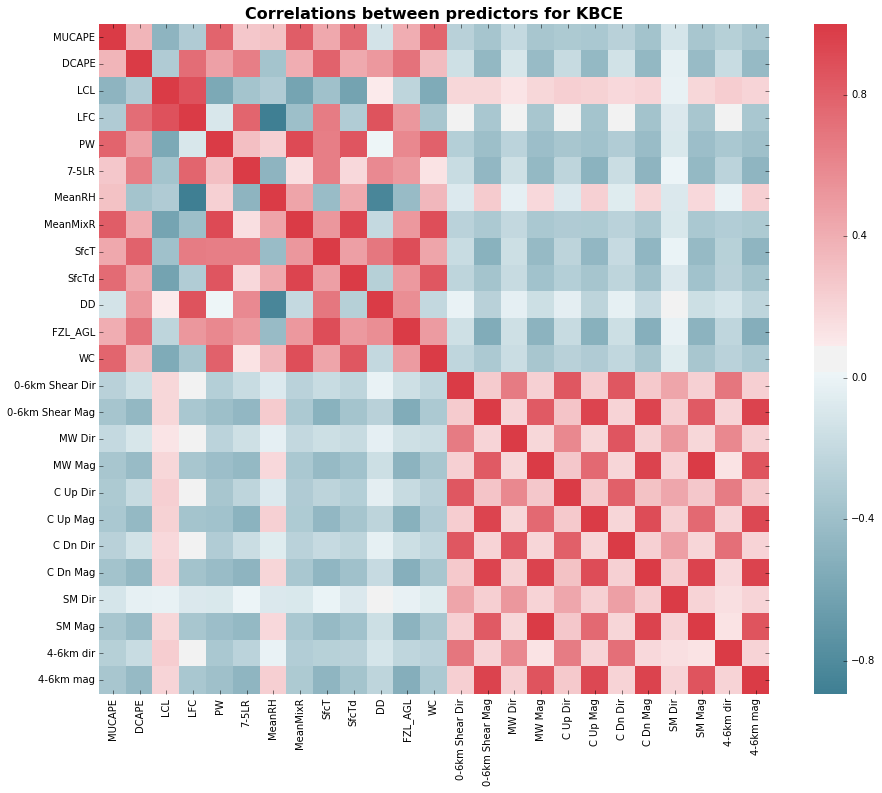

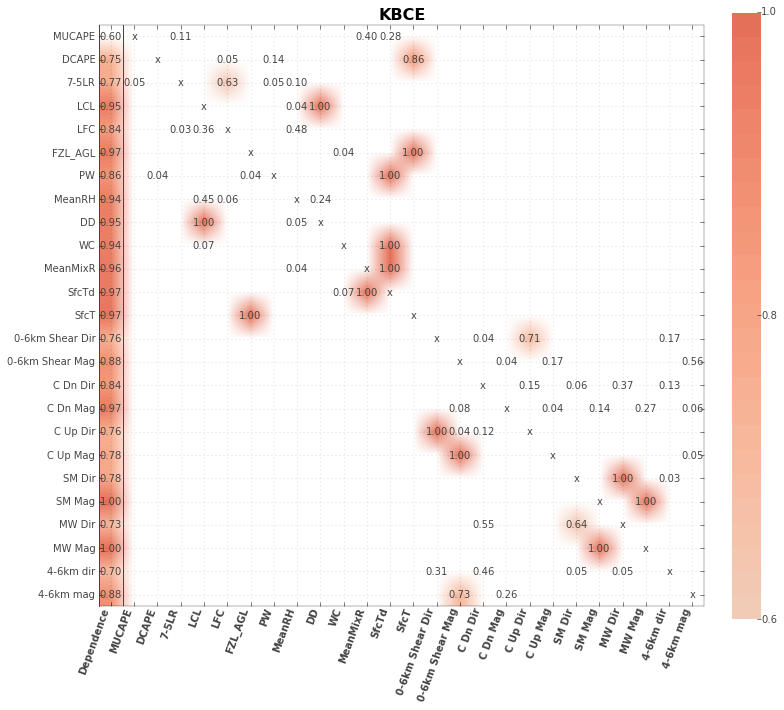

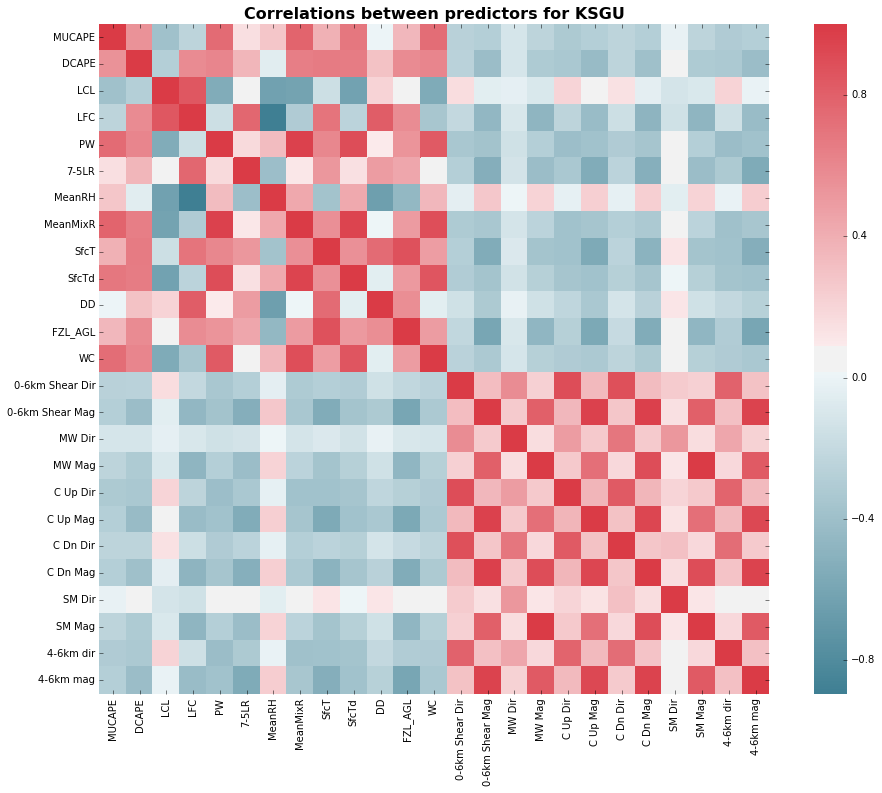

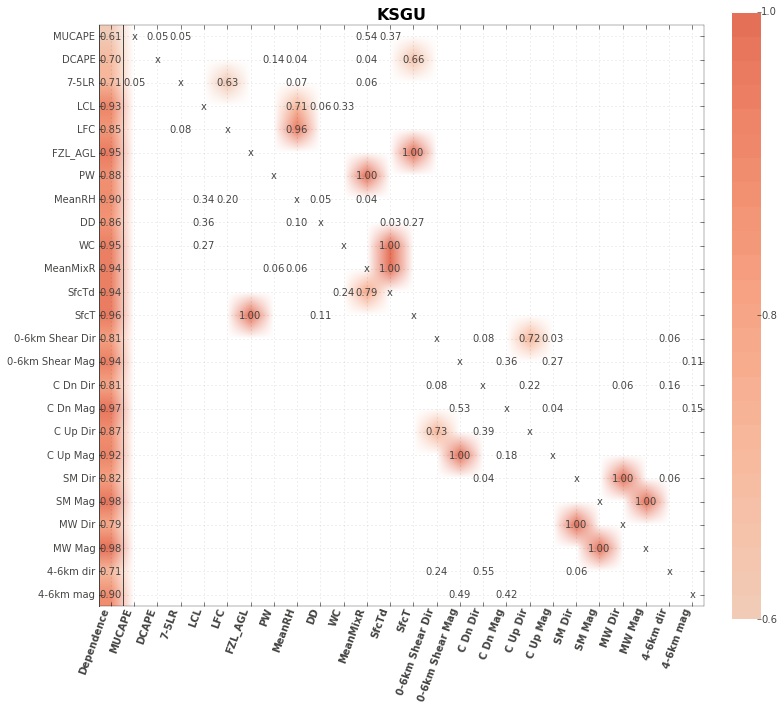

In [5]:
THERMO = ['MUCAPE', 'DCAPE', '7-5LR', 'LCL', 'LFC',
          'FZL_AGL','PW', 'MeanRH','DD', 'WC', 'MeanMixR', 'SfcTd', 'SfcT'] 

KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir','SM Mag',
       'MW Dir','MW Mag', '4-6km dir',
       '4-6km mag']

for csv in glob.glob('*nam.csv'):
    site_name = csv[:4]
    df = pd.read_csv(csv)
    [df.pop(x)for x in ['Basins', 'Year', 'Result']] #These aren't predictors
    plot_heatmap(df, site_name)
    df.dropna(subset=THERMO + KIN, inplace=True)
    predictors = df[THERMO + KIN]
    D = feature_dependence_matrix(predictors)
    plot_dependence_heatmap(D, figsize=(11,10), value_fontsize=10, label_fontsize=10)
    plt.title('{}'.format(site_name), fontweight='bold', fontsize=16)
    plt.savefig('Feature_Dependence{}'.format(site_name))

## Using 2018 as the "test dataset"

('4HV_', "Accuracy = 0.98,  Brier Score 0.02, Out of bag error score 0.04, AUC = 0.94, Cohen's Kappa -0.01")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,258,3
Flooding Observed,3,0


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
161,0.49,0.51,0.0,Incorrect
162,0.35,0.65,0.0,Incorrect
164,0.74,0.26,1.0,Incorrect
174,0.61,0.39,1.0,Incorrect
192,0.60,0.40,1.0,Incorrect
233,0.44,0.56,0.0,Incorrect


---------------------------------------------

('KPGA', "Accuracy = 0.95,  Brier Score 0.03, Out of bag error score 0.05, AUC = 0.96, Cohen's Kappa 0.46")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,254,8
Flooding Observed,5,6


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
134,0.18,0.82,0.0,Incorrect
162,0.75,0.25,1.0,Incorrect
163,0.60,0.40,1.0,Incorrect
168,0.67,0.33,1.0,Incorrect
173,0.84,0.16,1.0,Incorrect
177,0.54,0.46,1.0,Incorrect
190,0.48,0.52,0.0,Incorrect
192,0.48,0.52,0.0,Incorrect
196,0.21,0.79,0.0,Incorrect
197,0.26,0.74,0.0,Incorrect


---------------------------------------------

('KBCE', "Accuracy = 0.89,  Brier Score 0.06, Out of bag error score 0.09, AUC = 0.94, Cohen's Kappa 0.35")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,194,19
Flooding Observed,5,8


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
119,0.32,0.68,0.0,Incorrect
121,0.31,0.69,0.0,Incorrect
125,0.61,0.39,1.0,Incorrect
126,0.58,0.42,1.0,Incorrect
127,0.77,0.23,1.0,Incorrect
129,0.34,0.66,0.0,Incorrect
130,0.40,0.60,0.0,Incorrect
131,0.35,0.65,0.0,Incorrect
132,0.39,0.61,0.0,Incorrect
134,0.54,0.46,1.0,Incorrect


---------------------------------------------

('KSGU', "Accuracy = 0.96,  Brier Score 0.03, Out of bag error score 0.04, AUC = 0.95, Cohen's Kappa 0.43")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,268,7
Flooding Observed,3,4


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
162,0.45,0.55,0.0,Incorrect
163,0.28,0.72,0.0,Incorrect
164,0.81,0.19,1.0,Incorrect
168,0.28,0.72,0.0,Incorrect
171,0.42,0.58,0.0,Incorrect
172,0.38,0.62,0.0,Incorrect
183,0.72,0.28,1.0,Incorrect
192,0.47,0.53,0.0,Incorrect
202,0.77,0.23,1.0,Incorrect
244,0.48,0.52,0.0,Incorrect


---------------------------------------------



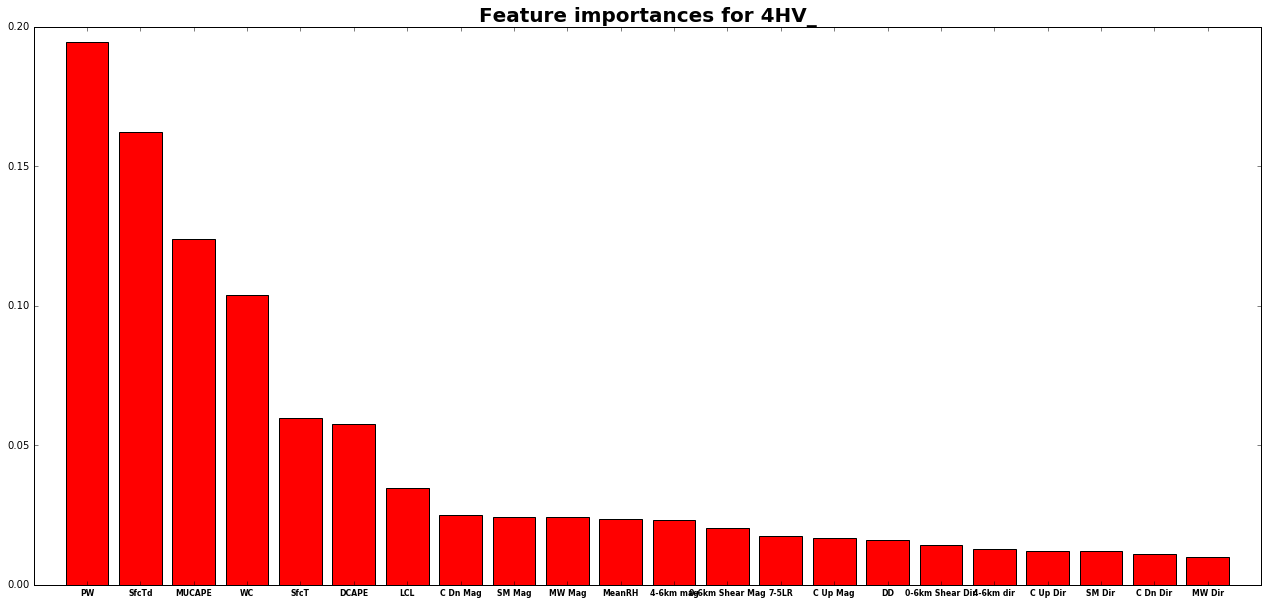

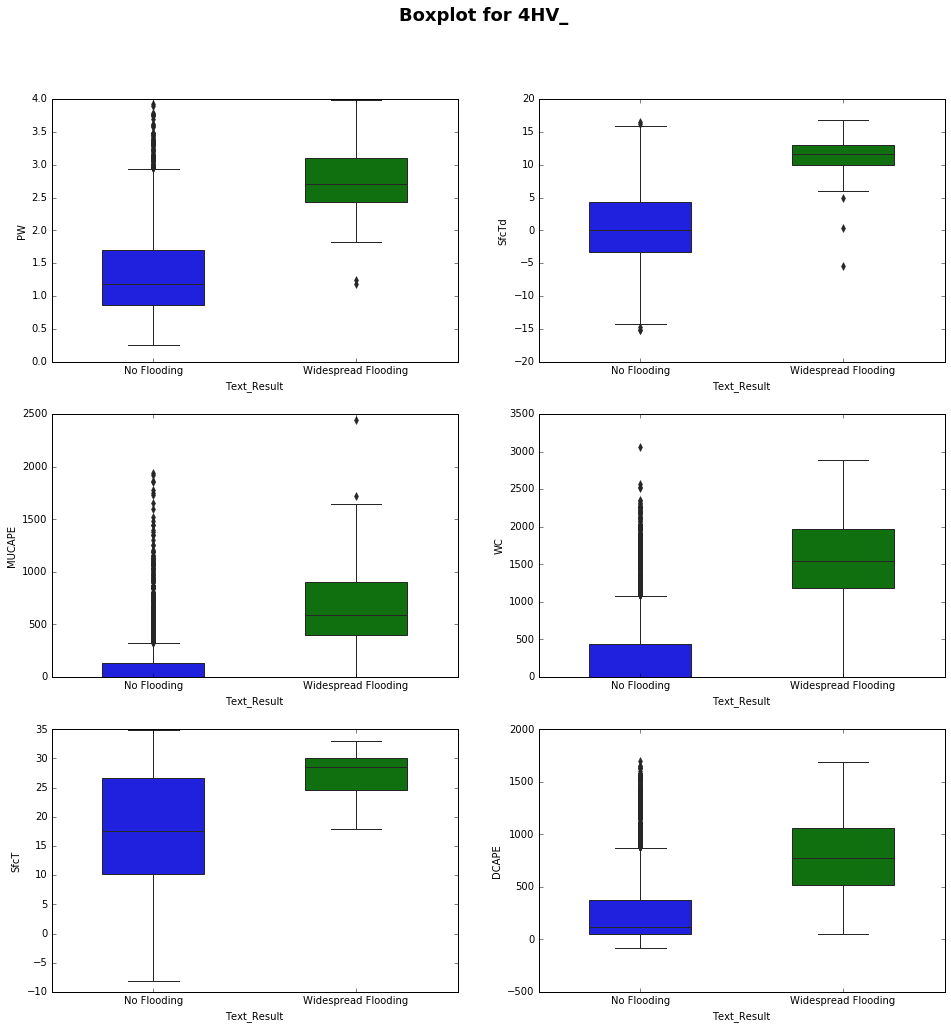

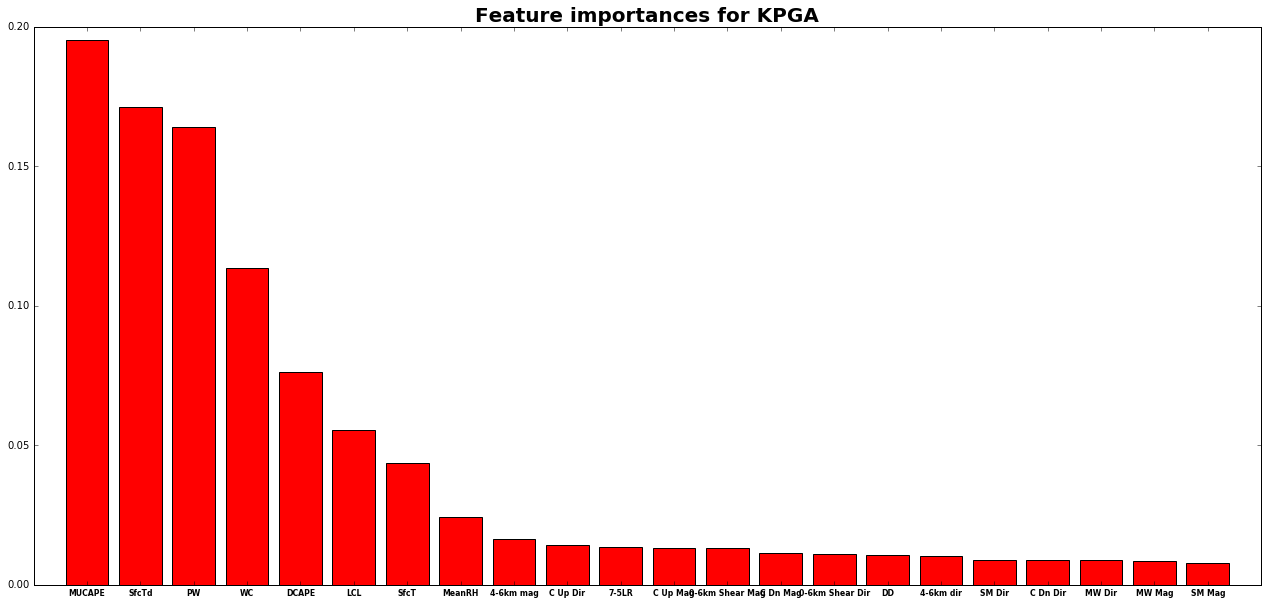

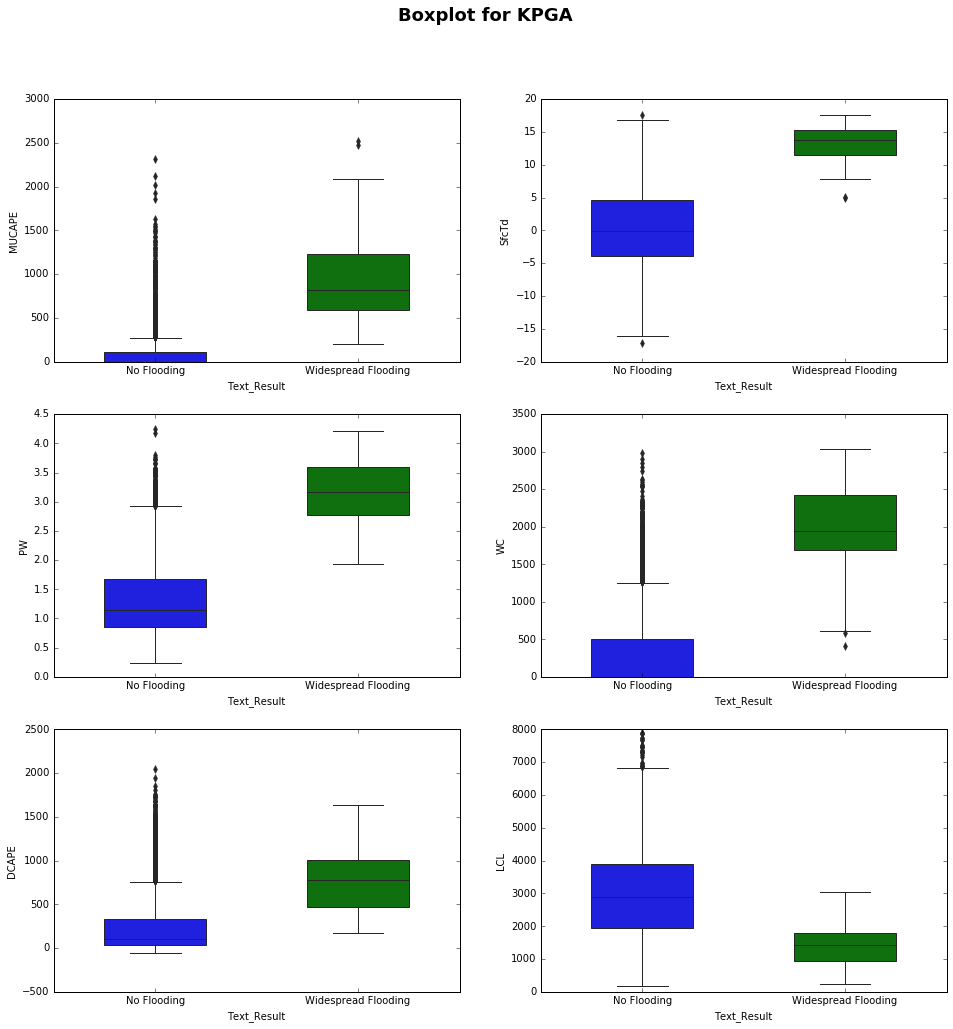

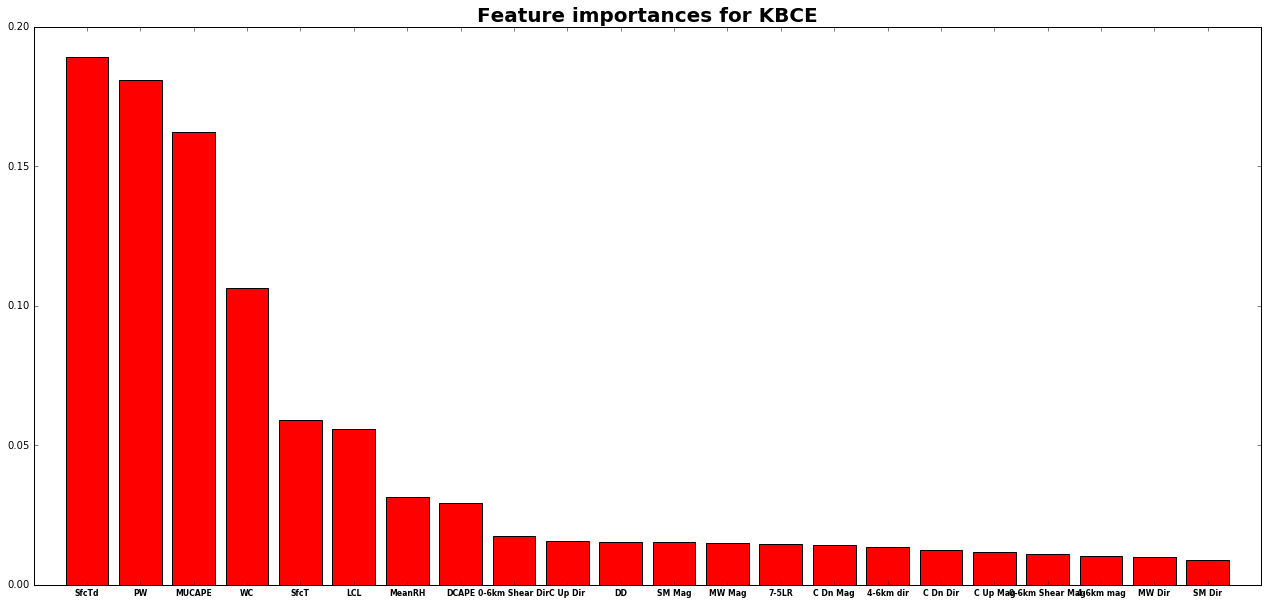

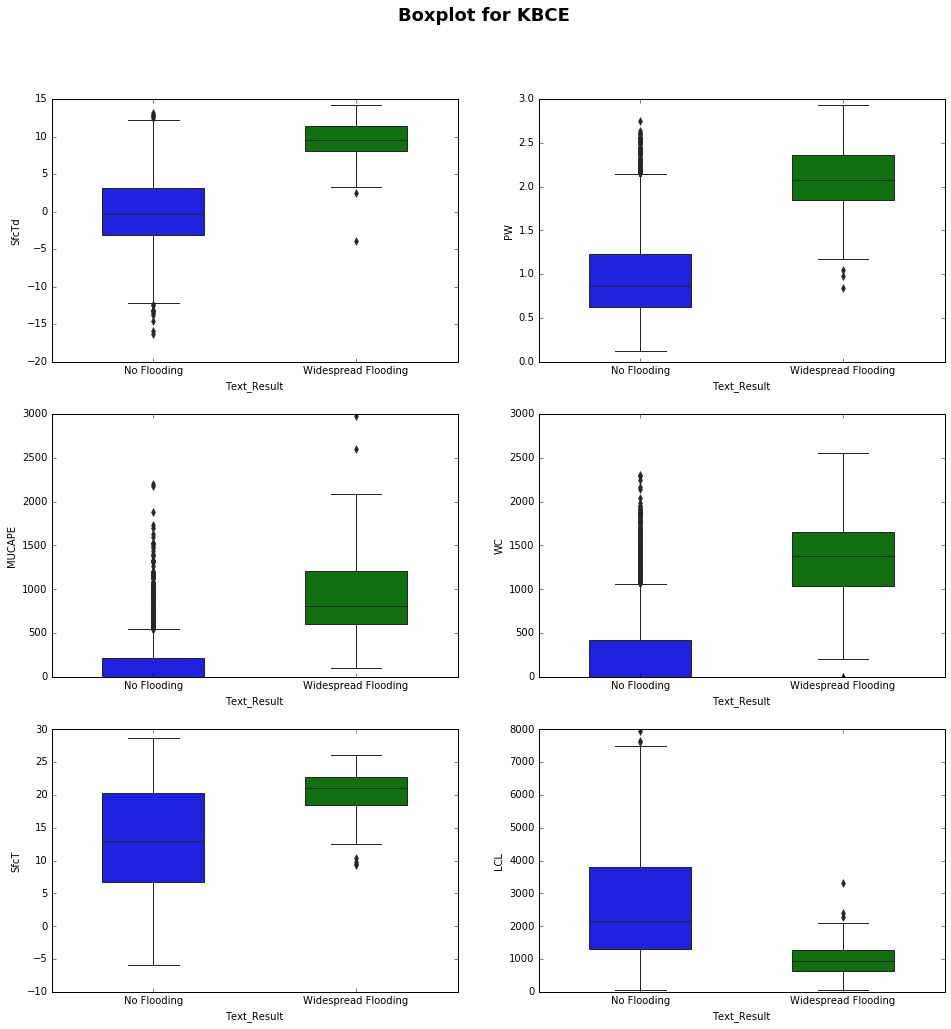

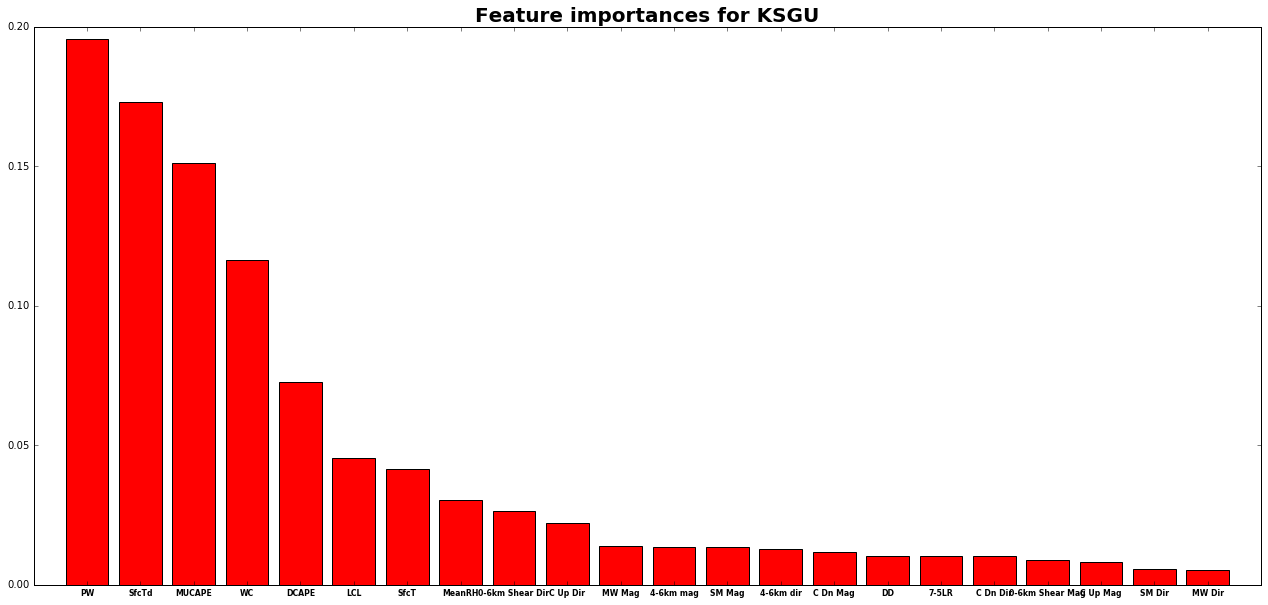

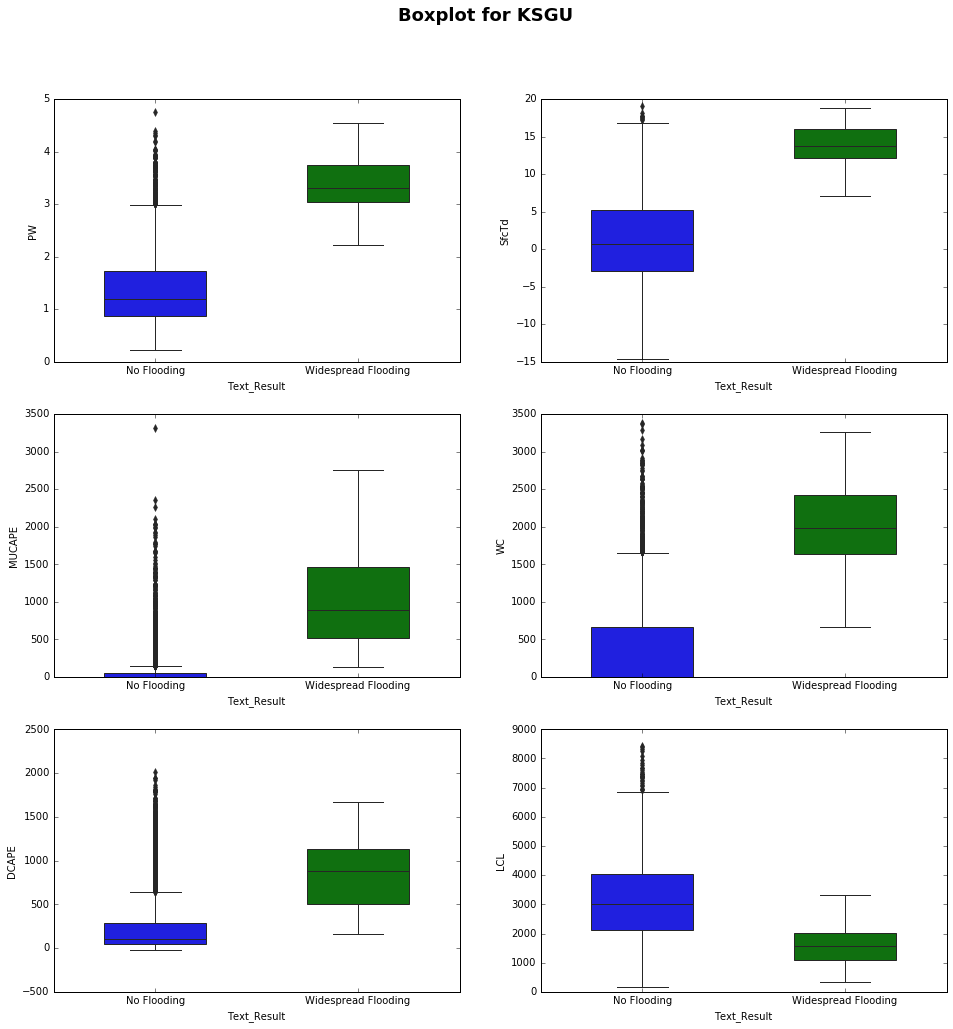

In [6]:
THERMO = ['MUCAPE', 'DCAPE', '7-5LR', 'LCL','PW', 'MeanRH','DD', 'WC', 'SfcTd', 'SfcT'] 

KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir','SM Mag',
       'MW Dir','MW Mag', '4-6km dir',
       '4-6km mag']
for csv in glob.glob('*nam.csv'):
    site_name = csv[:4]
    df = pd.read_csv(csv)
    #df = df[df['Year'] < 2018]
    if site_name == 'KBCE':
        df.loc[(df['Basins'] == 2), 'Result'] = 1
    if '4HV' or 'SGU' in site_name:
        df.loc[(df['Basins'] == 1), 'Result'] = 1
    df.dropna(subset=KIN + THERMO + ['Result'], inplace=True) 
  
    training_df = df[df['Year'] < 2018]
    test_df = df[df['Year'] == 2018]
    xtrain = training_df[THERMO + KIN]
    xtest = test_df[THERMO + KIN]
    ytrain = training_df.pop('Result')
    ytest = test_df.pop('Result')

    #xtest['random'] = np.random.random(size=len(xtest))
    #xtrain['random'] = np.random.random(size=len(xtrain))
    #Hyperparameters based on tuning
    clf = ens.RandomForestClassifier(n_estimators=2000, max_depth=15, min_samples_leaf=4,
                                     min_samples_split=4,oob_score=True,
                                     class_weight='balanced')
    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    accuracy = metrics.accuracy_score(ytest, y_pred)
    internal_score = 1 - clf.oob_score_
    yprob = clf.predict_proba(xtest)[0:, 1]
    brier_score = metrics.brier_score_loss(ytest, yprob)
    auc = metrics.roc_auc_score(ytest, yprob)
    feature_imp = pd.Series(clf.feature_importances_,
                            index=xtest.columns).sort_values(ascending=False)
    #feature_imp = permutation_importances(clf, xtrain, ytrain, oob_classifier_accuracy)
    cm = metrics.confusion_matrix(ytest, y_pred)
    index_names = ['No Flooding Observed', 'Flooding Observed']
    col_names = ['No Flooding Forecast', 'Flooding Forecast']
    cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
    ck = kappa(ytest, y_pred)
    print (site_name, 'Accuracy = {:3.2f}, '.format(accuracy) + 
           ' Brier Score {:3.2f}, '.format(brier_score) + 
           'Out of bag error score {:3.2f}, '.format(internal_score) +
           'AUC = {:3.2f}, '.format(auc) +  
           'Cohen\'s Kappa {:3.2f}'.format(ck))
    display(cm_df.head())
    importance_plot(xtest, feature_imp, site_name)
    boxplot(df, feature_imp, site_name)
    print '-' * 45 + '\n'
    flood = np.round(clf.predict_proba(xtest[:]), 2) 
    prob_df = pd.DataFrame(flood, columns=['Prob_No_Flood', 'Prob_Flood'])
    result_df = ytest.reset_index()
    prob_df['Flood?'] = result_df['Result']
    prob_df.loc[(prob_df['Prob_No_Flood'] > 0.5) &
                (prob_df['Flood?'] == 1), 'Model_Prediction'] = 'Incorrect'
    prob_df.loc[(prob_df['Prob_Flood'] > 0.5) & 
                (prob_df['Flood?'] == 0), 'Model_Prediction'] = 'Incorrect'
    prob_df.loc[(prob_df['Prob_No_Flood'] > 0.5) &
                (prob_df['Flood?'] == 0), 'Model_Prediction'] = 'Correct'
    prob_df.loc[(prob_df['Prob_Flood'] > 0.5) &
                (prob_df['Flood?'] == 1), 'Model_Prediction'] = 'Correct'
    prob_df.loc[(prob_df['Prob_Flood'] == 0.5), 'Model_Prediction'] = 'Tie'
    
    print 'These are the probablities for the predictions the model got incorrect'
    display(prob_df[prob_df['Model_Prediction'] == 'Incorrect'])
    print '-' * 45 + '\n'

## Using the typical test/train split from the whole dataset

('4HV_', "Accuracy = 0.96,  Brier Score 0.03, Out of bag error score 0.04, AUC = 0.92, Cohen's Kappa 0.23")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,627,13
Flooding Observed,16,5


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
32,0.45,0.55,0.0,Incorrect
49,0.77,0.23,1.0,Incorrect
66,0.77,0.23,1.0,Incorrect
96,0.42,0.58,0.0,Incorrect
126,0.76,0.24,1.0,Incorrect
179,0.38,0.62,0.0,Incorrect
200,0.57,0.43,1.0,Incorrect
204,0.67,0.33,1.0,Incorrect
312,0.81,0.19,1.0,Incorrect
371,0.65,0.35,1.0,Incorrect


---------------------------------------------

('KPGA', "Accuracy = 0.96,  Brier Score 0.03, Out of bag error score 0.05, AUC = 0.96, Cohen's Kappa 0.39")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,661,15
Flooding Observed,16,11


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
31,0.52,0.48,1.0,Incorrect
75,0.53,0.47,1.0,Incorrect
93,0.60,0.40,1.0,Incorrect
100,0.45,0.55,0.0,Incorrect
106,0.48,0.52,0.0,Incorrect
132,0.75,0.25,1.0,Incorrect
147,0.29,0.71,0.0,Incorrect
174,0.72,0.28,1.0,Incorrect
215,0.60,0.40,1.0,Incorrect
229,0.72,0.28,1.0,Incorrect


---------------------------------------------

('KBCE', "Accuracy = 0.90,  Brier Score 0.06, Out of bag error score 0.08, AUC = 0.94, Cohen's Kappa 0.47")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,472,45
Flooding Observed,13,32


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
1,0.41,0.59,0.0,Incorrect
5,0.27,0.73,0.0,Incorrect
15,0.34,0.66,0.0,Incorrect
28,0.65,0.35,1.0,Incorrect
57,0.26,0.74,0.0,Incorrect
59,0.48,0.52,0.0,Incorrect
73,0.48,0.52,0.0,Incorrect
84,0.40,0.60,0.0,Incorrect
90,0.30,0.70,0.0,Incorrect
104,0.45,0.55,0.0,Incorrect


---------------------------------------------

('KSGU', "Accuracy = 0.96,  Brier Score 0.03, Out of bag error score 0.04, AUC = 0.96, Cohen's Kappa 0.43")


,No Flooding Forecast,Flooding Forecast
No Flooding Observed,687,12
Flooding Observed,15,11


---------------------------------------------

These are the probablities for the predictions the model got incorrect


,Prob_No_Flood,Prob_Flood,Flood?,Model_Prediction
37,0.29,0.71,0.0,Incorrect
49,0.31,0.69,0.0,Incorrect
120,0.39,0.61,0.0,Incorrect
127,0.57,0.43,1.0,Incorrect
163,0.91,0.09,1.0,Incorrect
226,0.86,0.14,1.0,Incorrect
253,0.38,0.62,0.0,Incorrect
263,0.64,0.36,1.0,Incorrect
289,0.74,0.26,1.0,Incorrect
341,0.36,0.64,0.0,Incorrect


---------------------------------------------



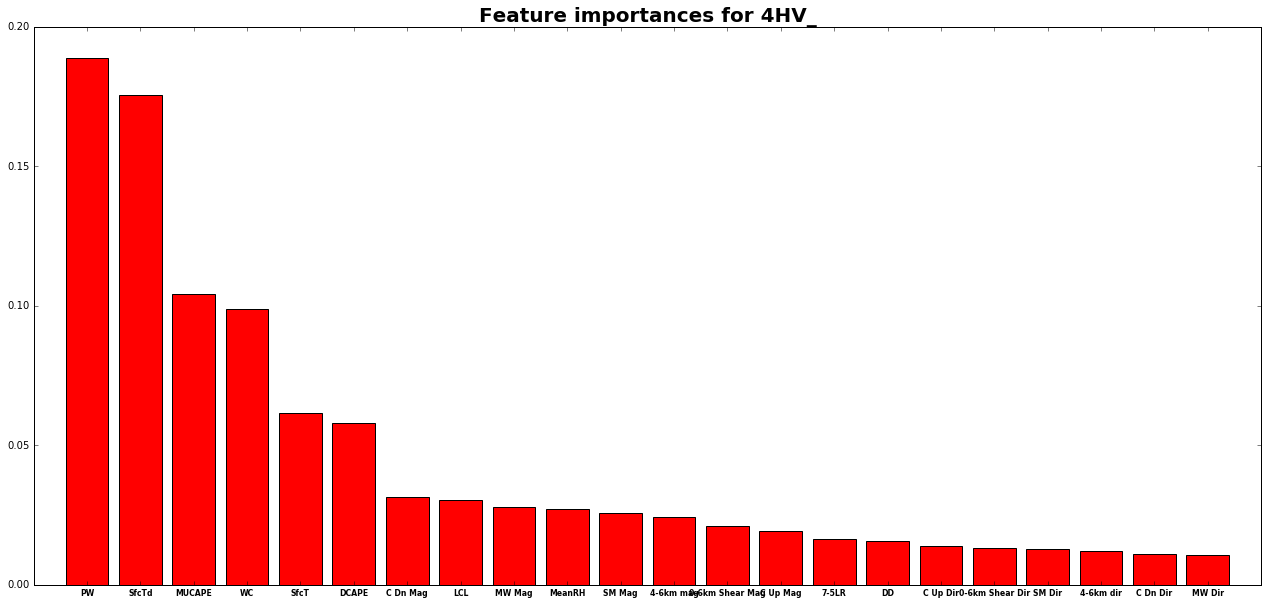

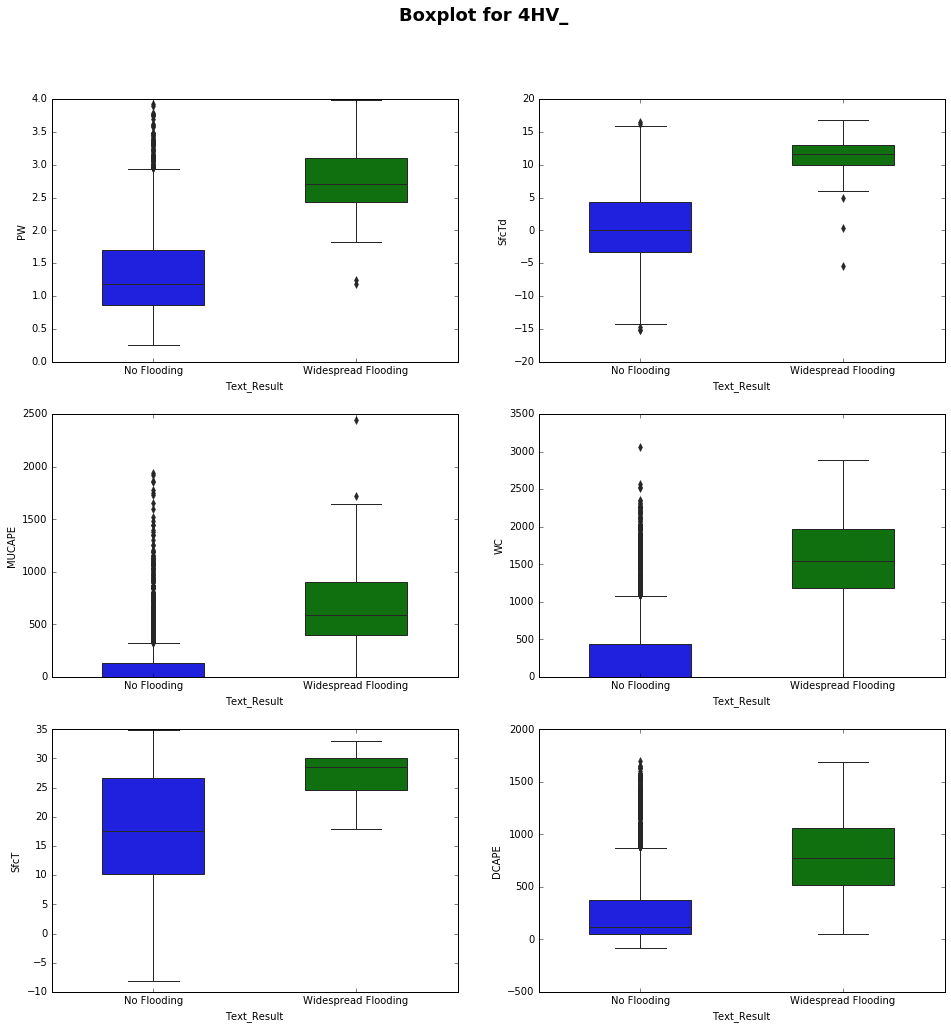

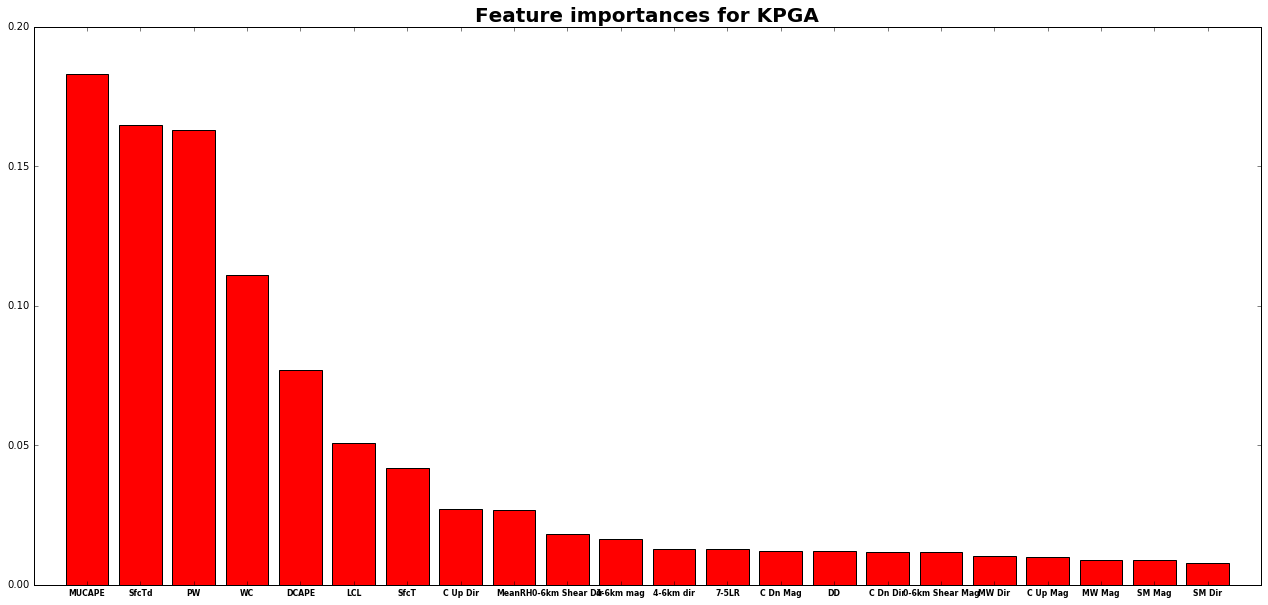

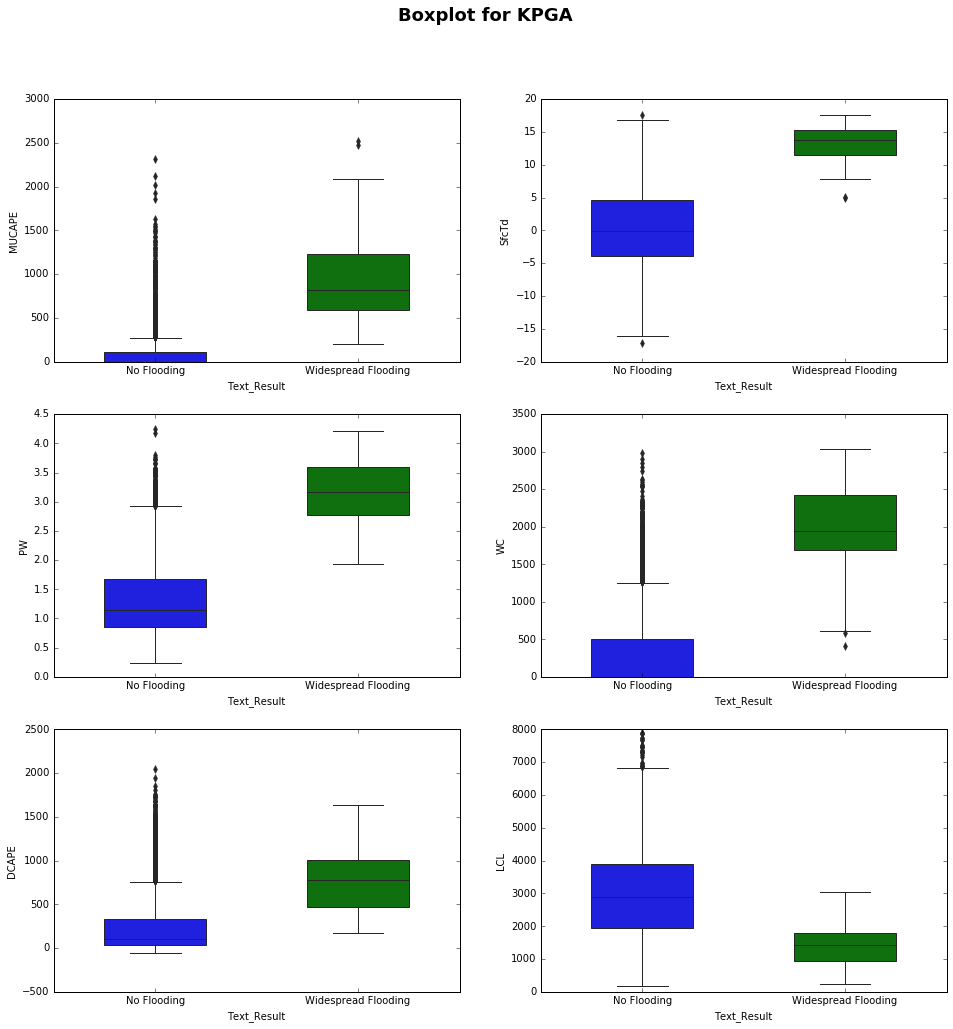

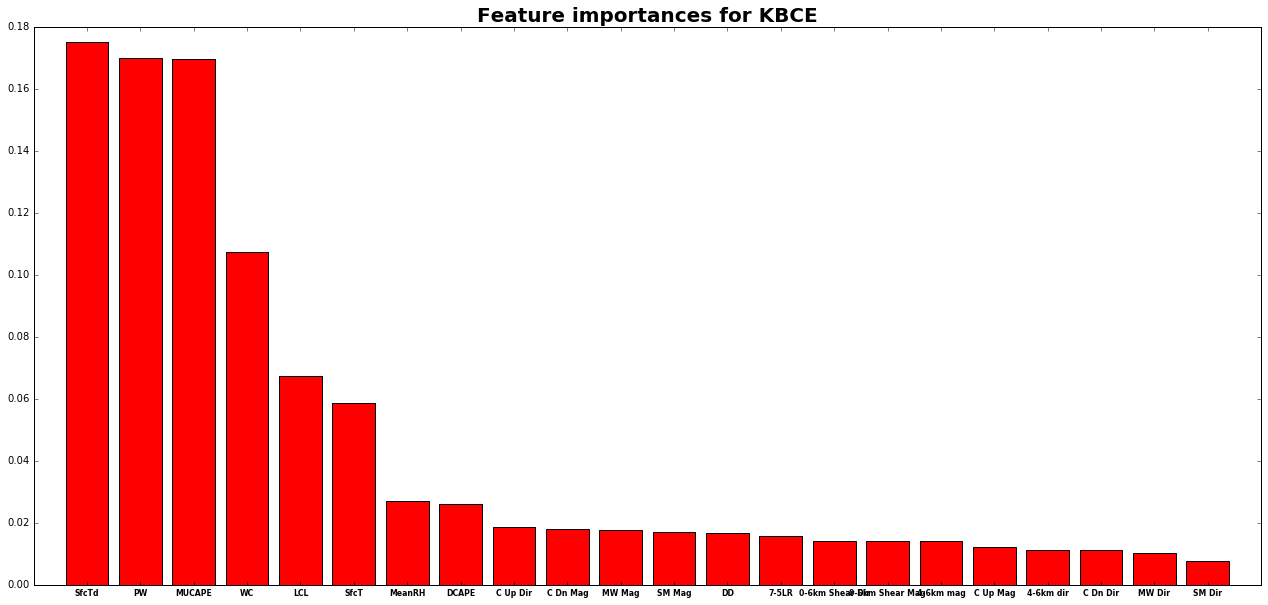

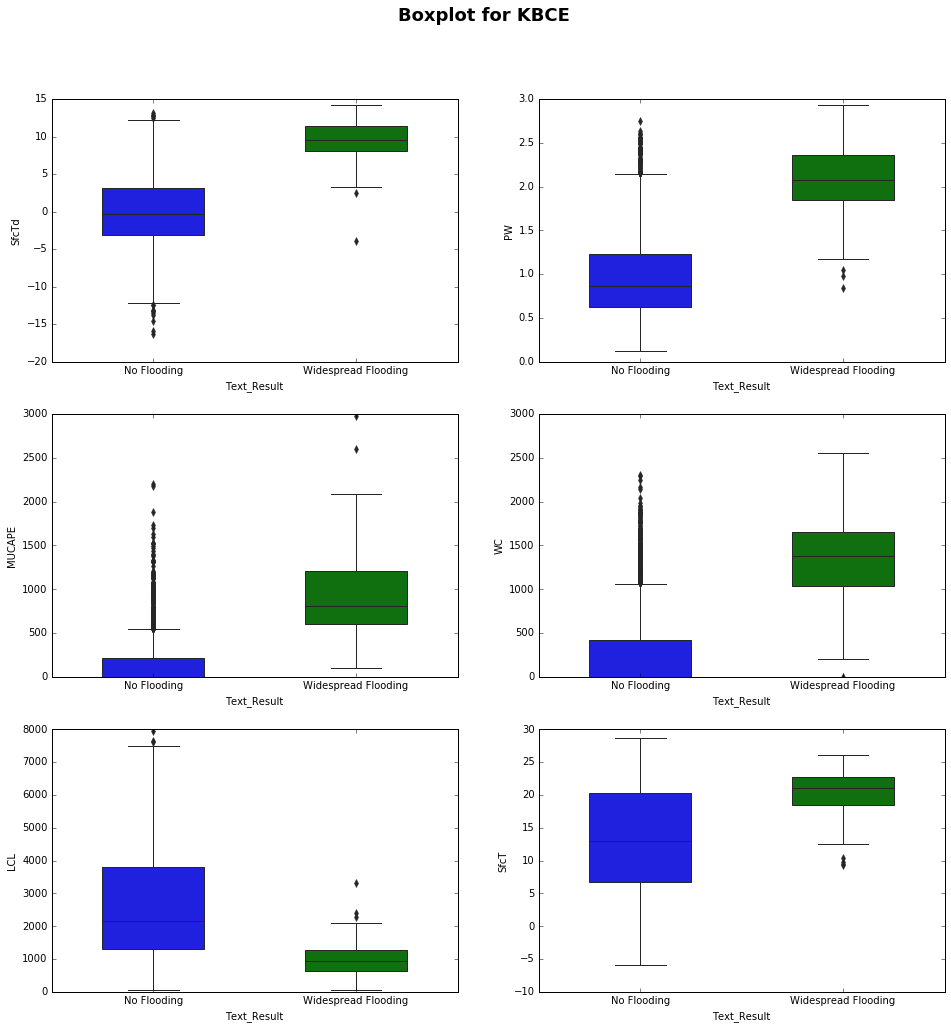

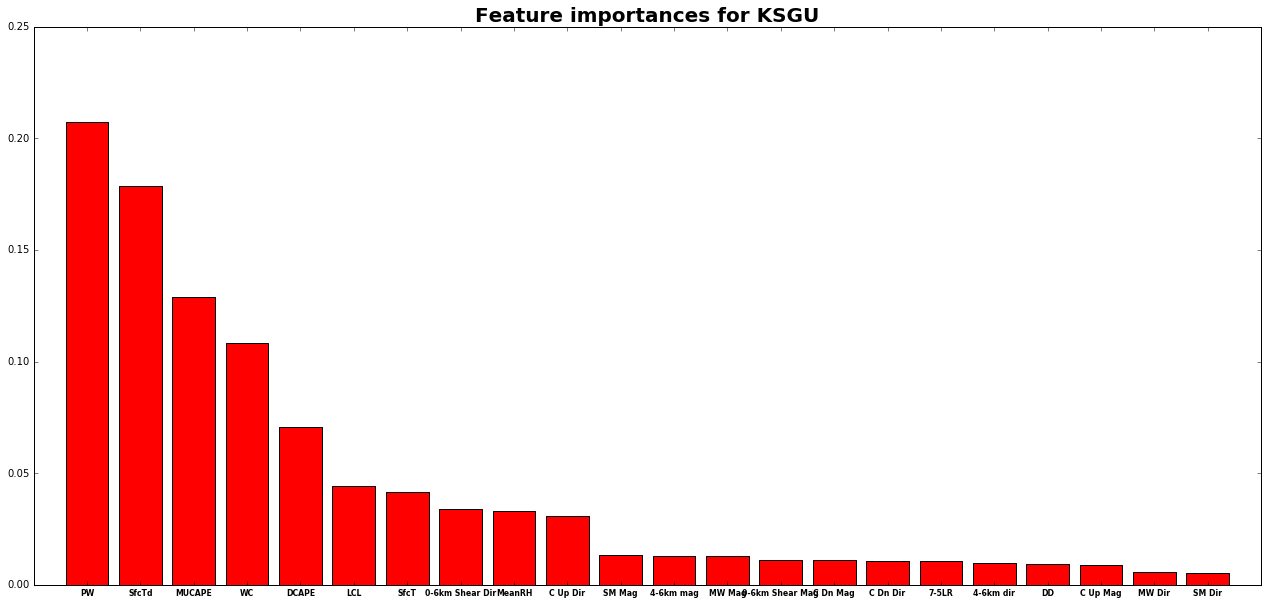

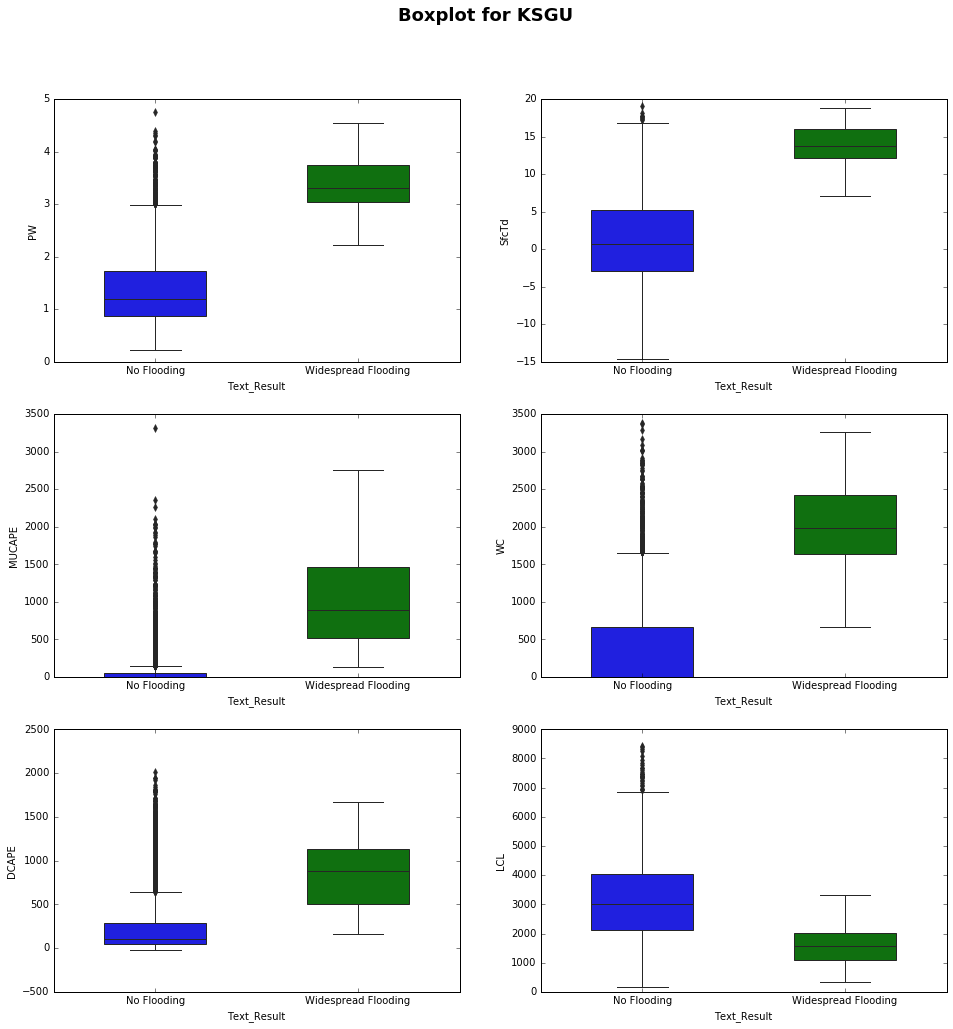

In [7]:
THERMO = ['MUCAPE', 'DCAPE', '7-5LR', 'LCL','PW', 'MeanRH','DD', 'WC', 'SfcTd', 'SfcT'] 

KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir','SM Mag',
       'MW Dir','MW Mag', '4-6km dir',
       '4-6km mag']
for csv in glob.glob('*nam.csv'):
    site_name = csv[:4]
    df = pd.read_csv(csv)
    if site_name == 'KBCE': # 3 Basins too stringent
        df.loc[(df['Basins'] == 2), 'Result'] = 1
    if '4HV' or 'SGU' in site_name: #Just not enough days with 2 Basins
        df.loc[(df['Basins'] == 1), 'Result'] = 1
    df.dropna(subset=KIN + THERMO + ['Result'], inplace=True) 
    predictors = df[THERMO + KIN]

    result = df['Result']
    
    xtrain, xtest, ytrain, ytest = train_test_split(predictors, 
                                                    result, 
                                                    test_size= 0.30) 
    #xtest['random'] = np.random.random(size=len(xtest))
    #xtrain['random'] = np.random.random(size=len(xtrain))
    #Hyperparameters based on tuning
    clf = ens.RandomForestClassifier(n_estimators=2000, max_depth=15, min_samples_leaf=4,
                                     min_samples_split=4,oob_score=True,
                                     class_weight='balanced')
    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    accuracy = metrics.accuracy_score(ytest, y_pred)
    internal_score = 1 - clf.oob_score_
    yprob = clf.predict_proba(xtest)[0:, 1]
    brier_score = metrics.brier_score_loss(ytest, yprob)
    auc = metrics.roc_auc_score(ytest, yprob)
    feature_imp = pd.Series(clf.feature_importances_,
                            index=xtest.columns).sort_values(ascending=False)
    #feature_imp = permutation_importances(clf, xtrain, ytrain, oob_classifier_accuracy)
    cm = metrics.confusion_matrix(ytest, y_pred)
    index_names = ['No Flooding Observed', 'Flooding Observed']
    col_names = ['No Flooding Forecast', 'Flooding Forecast']
    cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
    ck = kappa(ytest, y_pred)
    print (site_name, 'Accuracy = {:3.2f}, '.format(accuracy) + 
           ' Brier Score {:3.2f}, '.format(brier_score) + 
           'Out of bag error score {:3.2f}, '.format(internal_score) +
           'AUC = {:3.2f}, '.format(auc) +  
           'Cohen\'s Kappa {:3.2f}'.format(ck))
    display(cm_df.head())
    importance_plot(xtest, feature_imp, site_name)
    boxplot(df, feature_imp, site_name)
    print '-' * 45 + '\n'
    flood = np.round(clf.predict_proba(xtest[:]), 2) 
    prob_df = pd.DataFrame(flood, columns=['Prob_No_Flood', 'Prob_Flood'])
    result_df = ytest.reset_index()
    prob_df['Flood?'] = result_df['Result']
    prob_df.loc[(prob_df['Prob_No_Flood'] > 0.5) &
                (prob_df['Flood?'] == 1), 'Model_Prediction'] = 'Incorrect'
    prob_df.loc[(prob_df['Prob_Flood'] > 0.5) & 
                (prob_df['Flood?'] == 0), 'Model_Prediction'] = 'Incorrect'
    prob_df.loc[(prob_df['Prob_No_Flood'] > 0.5) &
                (prob_df['Flood?'] == 0), 'Model_Prediction'] = 'Correct'
    prob_df.loc[(prob_df['Prob_Flood'] > 0.5) &
                (prob_df['Flood?'] == 1), 'Model_Prediction'] = 'Correct'
    prob_df.loc[(prob_df['Prob_Flood'] == 0.5), 'Model_Prediction'] = 'Tie'
    
    print 'These are the probablities for the predictions the model got incorrect'
    display(prob_df[prob_df['Model_Prediction'] == 'Incorrect'])
    print '-' * 45 + '\n'